# Explore here

In [84]:
# IMPORT LIBRARIES

# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels (manual ARIMA, diagnostics, plots)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# pmdarima (and auto_arima for automated parameter search)
import pmdarima as pm
from pmdarima.arima import auto_arima

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Saving models
import joblib

import warnings
warnings.filterwarnings('ignore')

In [85]:
# LOADING ORIGINAL DATA
data = "https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv"
df = pd.read_csv(data)
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


## 1. Exploratory Data Analysis

In [86]:
#Dataset dimension
rows, column = df.shape
print(f'{rows} rows and {column} columns')

366 rows and 2 columns


In [87]:
# Get information cabout range index, number of columns and labels, data types, and the number of cells in each column (non-null values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [88]:
# Convert date column to datetime & set index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

ts = df['sales']
print(f"Observation Count: {len(ts)} days")
print(f"From: {ts.index[0].date()} → To: {ts.index[-1].date()}")

Observation Count: 366 days
From: 2022-09-03 → To: 2023-09-03


## Daily Sales Visual

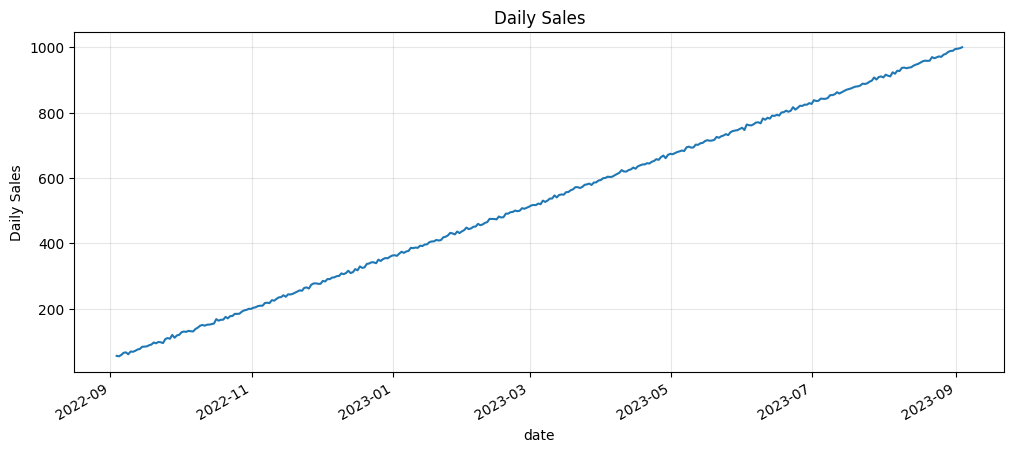

In [89]:
df['sales'].plot(figsize=(12,5))
plt.title("Daily Sales")
plt.xticks()
plt.ylabel('Daily Sales')
plt.grid(True, alpha=0.3)
plt.show()

## EDA Questions

### Tensor (frequency)
1. What is the time series tensor?

In [90]:
freq = pd.infer_freq(df.index)
# If infer_freq returns 'None' because of index not being regular will show "Irregular"
print("Data Frequency:", freq if freq else "Irregular")


Data Frequency: D


### Series Decomp (Trend, Seasonal and Noise)
- What is the trend?
- Is there variability or noise?

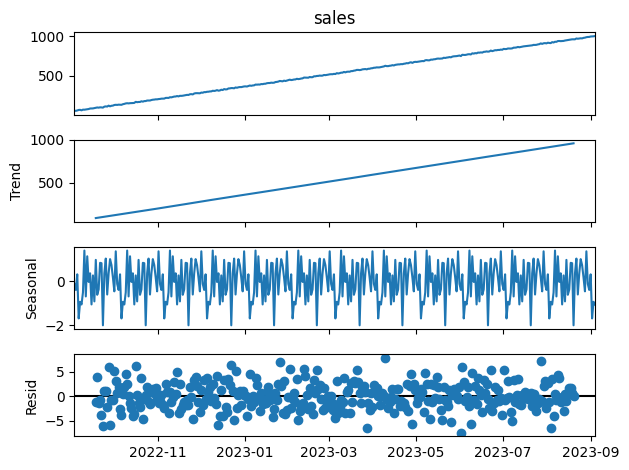

In [91]:
# Series Decomp (Trend, Seasonal and Noise)
decomp = seasonal_decompose(ts, model='additive', period=30)
decomp.plot()
plt.show()


#### Trend Analysis

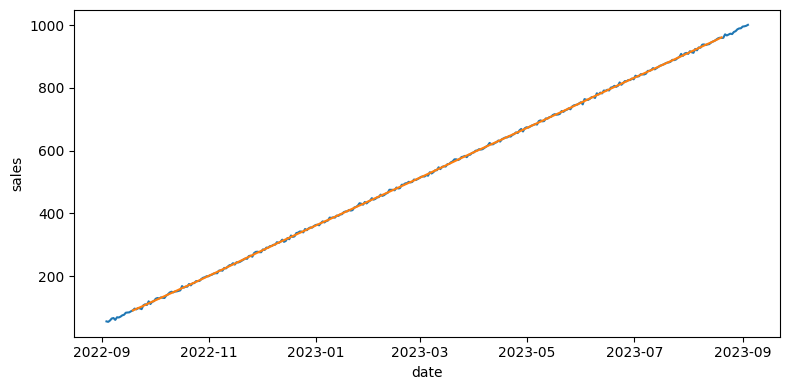

In [92]:
trend = decomp.trend

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### Seasonal Analysis

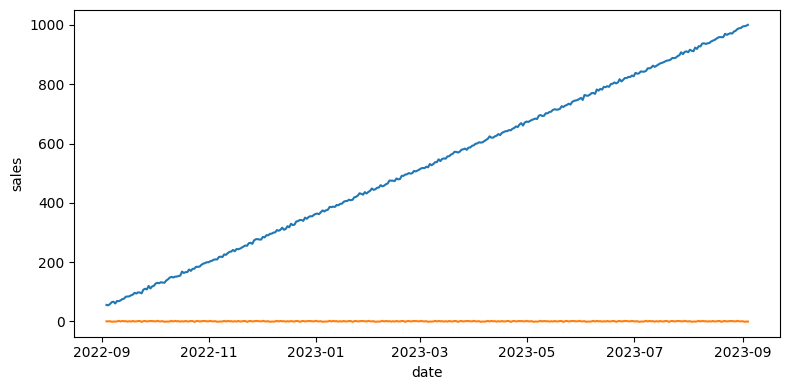

In [93]:
seasonal = decomp.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

#### Residual Analysis

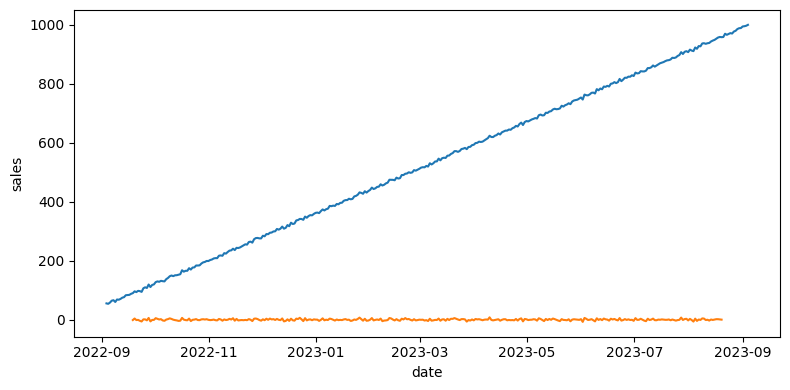

In [94]:
residual = decomp.resid

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

#### Stationarity (ADF test)
- Is it stationary?

In [95]:
def test_stationarity(timeseries, alpha = 0.05):
    print("Dickey-Fuller Test Results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    
    #Extract p-value
    p_value = dftest[1]

    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
        if p_value < alpha:
            conclusion = "The series is **Stationary**"
        else:
            conclusion = "The series is **Non-Stationary**"
    dfoutput["Conclusion (alpha={})".format(alpha)] = conclusion
    return dfoutput

test_stationarity(ts)

Dickey-Fuller Test Results:


Test Statistic                                         0.545414
p-value                                                 0.98619
#Lags Used                                                 13.0
Number of Observations Used                               352.0
Critical Value (1%)                                   -3.449065
Critical Value (5%)                                   -2.869786
Critical Value (10%)                                  -2.571163
Conclusion (alpha=0.05)        The series is **Non-Stationary**
dtype: object

##### Differencing the Series

Differencing to stabilize the mean

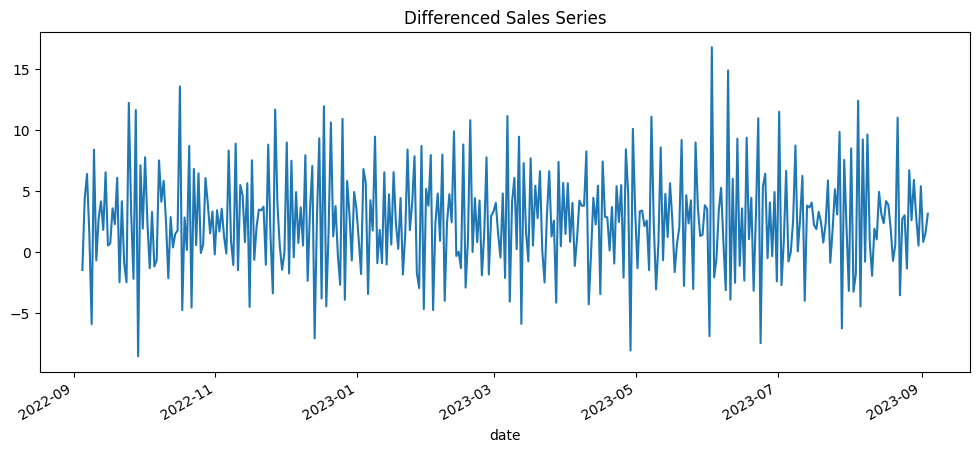

In [96]:
ts_diff = df['sales'].diff().dropna()

ts_diff.plot(figsize=(12,5))
plt.title("Differenced Sales Series")
plt.show()


##### Check Stationarity Again

In [97]:
test_stationarity(ts_diff)

Dickey-Fuller Test Results:


Test Statistic                                    -9.430263
p-value                                                 0.0
#Lags Used                                             12.0
Number of Observations Used                           352.0
Critical Value (1%)                               -3.449065
Critical Value (5%)                               -2.869786
Critical Value (10%)                              -2.571163
Conclusion (alpha=0.05)        The series is **Stationary**
dtype: object

#### _EDA Questions Resolution Summary_
1. What is the time series tensor?
    - Tensor: **Daily**
2. What is the trend?
    - Seasonal decomposition shows a clear **Upward** trend over time
3. Is it stationary?
    - The Dickey‑Fuller test gave a p‑value above 0.05, which means we cannot reject the null hypothesis. This indicates the series is not stationary — the average sales increase over time, showing a clear upward trend.
4. Is there variability or noise?
    - Residuals from decomposition show daily variability around the trend

## ACF & PACF

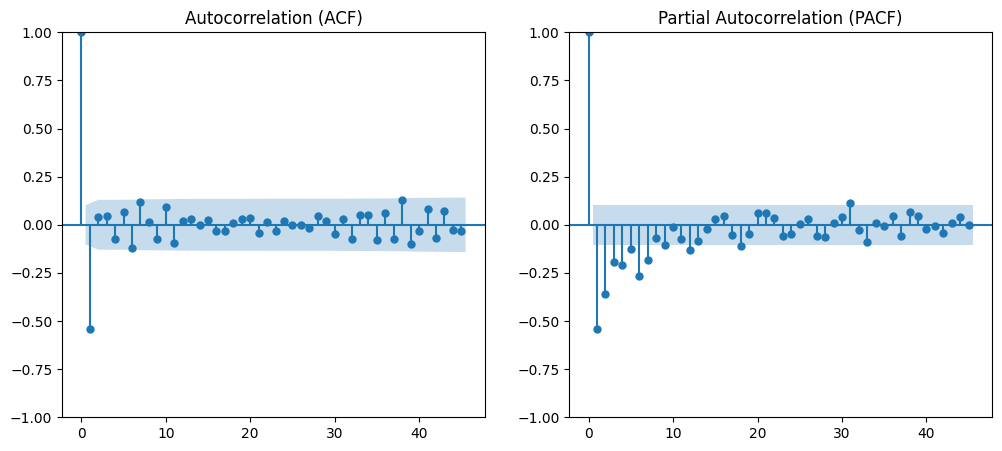

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ACF to determine q
plot_acf(ts_diff, lags=45, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")

# PACF to determine q
plot_pacf(ts_diff, lags=45, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")

plt.show()

## ARIMA Model

In [99]:
p = 1
d = 1
q = 1

arima_model = ARIMA(ts, order=(p,d,q))

arima_result = arima_model.fit()

In [100]:
# Forecast next 30 days
predictions = arima_result.predict(start=len(ts), end=len(ts)+30)
predictions.reset_index()

,index,predicted_mean
0,2023-09-04 17:10:08.079328,1003.052388
1,2023-09-05 17:10:08.079328,1005.621989
2,2023-09-06 17:10:08.079328,1008.191589
3,2023-09-07 17:10:08.079328,1010.761187
4,2023-09-08 17:10:08.079328,1013.330783
5,2023-09-09 17:10:08.079328,1015.900378
6,2023-09-10 17:10:08.079328,1018.469971
7,2023-09-11 17:10:08.079328,1021.039562
8,2023-09-12 17:10:08.079328,1023.609152
9,2023-09-13 17:10:08.079328,1026.178740


### Forecast Graph

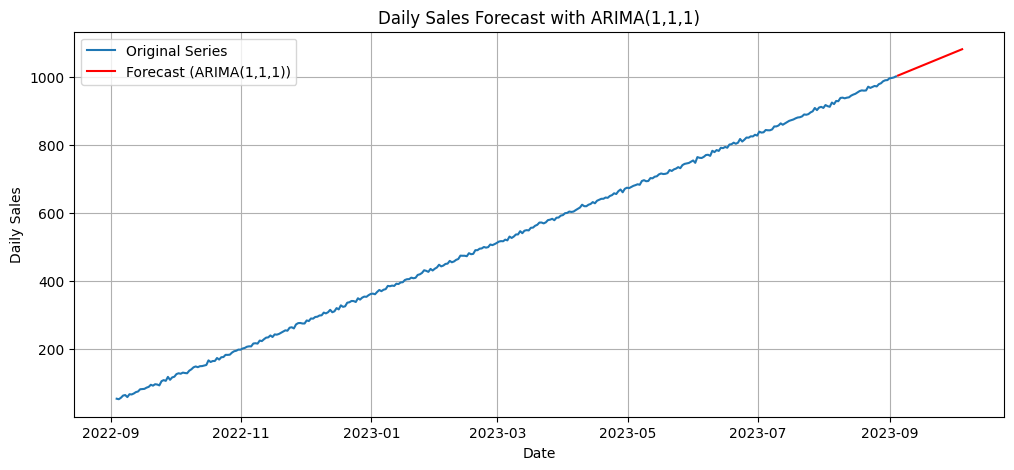

In [101]:
# Graph Forecast
plt.figure(figsize=(12,5))
plt.plot(ts, label='Original Series')
plt.plot(predictions, label='Forecast (ARIMA(1,1,1))', color='red')
plt.title("Daily Sales Forecast with ARIMA(1,1,1)")
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.legend()
plt.grid(True)
plt.show()

### Train

In [102]:
model = auto_arima(ts, seasonal = True, trace = True, m = 30)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=1845.250, Time=3.44 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=1971.739, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2209.657, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=1843.275, Time=2.75 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=1843.274, Time=0.43 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=1843.223, Time=3.16 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=1845.261, Time=11.58 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=1847.247, Time=12.81 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=1843.128, Time=3.72 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=1843.586, Time=0.17 sec
 ARIMA(1,1,2)(2,0,0)[30] intercept   : AIC=inf, Time=10.70 sec
 ARIMA(1,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(1,1,2)(0,0,1)[30] interc

### Predict

Forecst next 30 days after Train

In [104]:
forecast = model.predict(n_periods=30)
forecast.reset_index()

,index,0
0,2023-09-04 17:10:08.079328,1002.528926
1,2023-09-05 17:10:08.079328,1004.691433
2,2023-09-06 17:10:08.079328,1007.518935
3,2023-09-07 17:10:08.079328,1009.561425
4,2023-09-08 17:10:08.079328,1012.304812
5,2023-09-09 17:10:08.079328,1015.245347
6,2023-09-10 17:10:08.079328,1017.945463
7,2023-09-11 17:10:08.079328,1020.659419
8,2023-09-12 17:10:08.079328,1023.065594
9,2023-09-13 17:10:08.079328,1025.614857


### Forecast Predict Plot

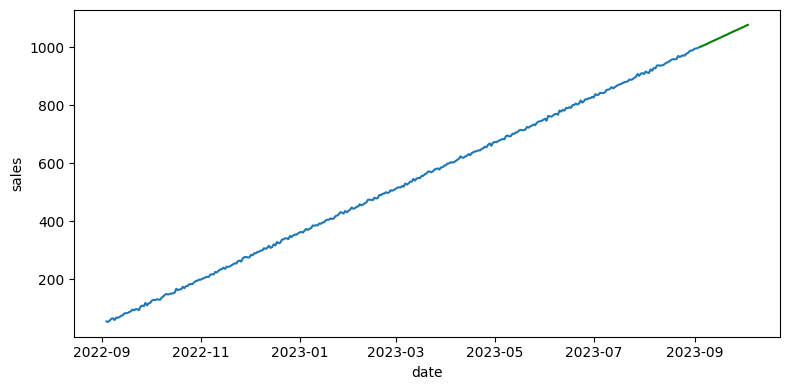

In [ ]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

## Final Conclusions
The ARIMA(1,1,1) model gave us a reasonable forecast for the next 30 days, continuing the upward trend we’ve seen in daily sales. The green line shows how the model projects future values based on past patterns; it doesn’t capture sudden jumps, but it follows the general rhythm well.

We didn’t split into train/test or calculate error metrics, but visually the forecast looks consistent with the recent growth. That suggests the model is picking up the main trend.

I also tried auto_arima to let the algorithm choose the best parameters. But it seems that the parameteres didn't change as much. The forecast was very similar to the manual ARIMA, which reassures me that the model is stable and not overly sensitive to parameter tuning.

**Conclusion**: ARIMA gives a solid baseline for forecasting sales, especially when the trend is clear, gives us a good starting point to plan ahead.

In [120]:
# Save the fitted ARIMA model
joblib.dump(arima_result, "/workspaces/forecasting-msalaverri/models/sales_arima_model.pkl")

print("Model saved to models/sales_arima_model.pkl")

Model saved to models/sales_arima_model.pkl
